In [ ]:
!pip install antigranular


In [64]:

import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Iris Dataset")

Loading dataset "Iris Dataset" to the kernel...
Dataset "Iris Dataset" loaded to the kernel as iris_dataset
Connected to Antigranular server session id: 4ac85277-5d26-4f8e-ba87-d85deba252e1, the session will time out if idle for 60 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


**Loading the Dataset**

In [65]:
%%ag
from ag_utils import export , load_dataset
import pandas as pd
from op_pandas import PrivateDataFrame


In [66]:
%%ag
x = load_dataset("Iris Dataset")
train_x = x["train_x"]
train_y = x["train_y"]
test_x = x["test_x"]

In [67]:
%%ag
export(train_x.describe(eps=0.1) , 'result')

Setting up exported variable in local environment: result


In [68]:
result

,sepal_length,sepal_width,petal_length,petal_width
count,129.000000,129.000000,129.000000,129.000000
mean,7.086802,2.000000,1.000000,2.500000
std,0.741762,0.743316,2.046669,1.019708
min,4.300000,2.000000,1.000000,0.100000
25%,5.228661,2.697337,3.913907,1.144988
50%,6.810895,3.963554,6.635303,0.254051
75%,7.580130,3.030743,1.466417,2.482057
max,6.466205,3.696621,6.655442,2.484474


**Using Applymap**

In [69]:
%%ag

# encoding categoricals
def func_(x:str)-> int:
  if x == 'Iris-setosa':
    return 0
  elif x == 'Iris-versicolor':
    return 1
  else: # Iris-virginica
    return 2

train_y_encoded = train_y.applymap(func_ , output_bounds={'species':(0,2)})

In [70]:
%%ag
train_data = train_x.join(train_y_encoded , how="left")
export(train_data.describe(eps=0.5) , 'result')

Setting up exported variable in local environment: result


In [71]:
result

,sepal_length,sepal_width,petal_length,petal_width,species
count,62.000000,62.000000,62.000000,62.000000,62.000000
mean,7.700000,2.000000,6.700000,2.235509,0.732322
std,0.135092,0.688491,2.713215,0.841902,0.383822
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,7.295818,2.404865,5.598989,2.469707,1.407461
50%,5.552793,2.067578,1.011711,1.104709,1.116098
75%,7.632187,3.165328,1.001660,1.153030,1.493705
max,4.426260,3.268965,3.825359,2.443807,0.473006


**Exploring data using snsql**

In [72]:
%%ag
import op_snsql

In [73]:
%%ag
privacy = op_snsql.Privacy(epsilon=1.0)
reader = op_snsql.from_df(df=train_y_encoded, privacy=privacy)

In [74]:
%%ag
# get idea about expected privacy_cost that will be spent.
total_cost = reader.get_privacy_cost([
    "SELECT COUNT(species) as setosa from df.table WHERE species == 0",
    "SELECT COUNT(species) as versicolor from df.table WHERE species == 1",
    "SELECT COUNT(species) as virginica from df.table WHERE species == 2"
    ])
export(str(total_cost) , "total_cost")

Setting up exported variable in local environment: total_cost


In [75]:
total_cost # (epsilon , delta)

'(6.0, 3.552713678800501e-15)'

In [76]:
%%ag
# execute returns in the following format -> [[column_names] , [values]]
c0 = reader.execute("SELECT COUNT(species) as setosa from df.table WHERE species == 0")
c1 = reader.execute("SELECT COUNT(species) as versicolor from df.table WHERE species == 1")
c2 = reader.execute("SELECT COUNT(species) as virginica from df.table WHERE species == 2")

export(str([c0,c1,c2]) , 'counts')

Setting up exported variable in local environment: counts


In [77]:
count_data = eval(counts)
col , count = [i[0][0] for i in count_data] , [i[1][0] for i in count_data]
print(f"col = {col} , count = {count}")

col = ['setosa', 'versicolor', 'virginica'] , count = [40, 40, 37]


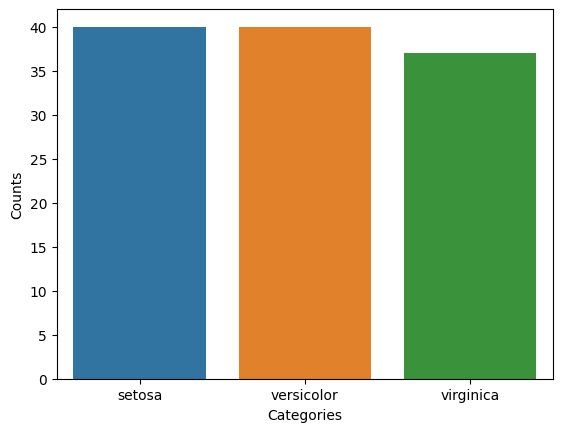

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=col , y=count)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

**Evaluating correlation of the columns**

In [79]:
%%ag
priv_corr = train_x.corr(eps=7)
export(priv_corr , 'priv_corr')

Setting up exported variable in local environment: priv_corr


<Axes: >

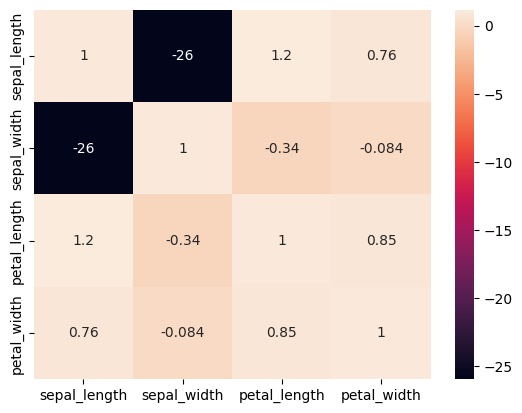

In [80]:
import pandas as pd
result = priv_corr.apply(pd.to_numeric, errors='coerce').astype(float)
sns.heatmap(result , annot = True)

**Implementing RandomForestClassier using diffprivlib**

In [81]:
%%ag
from op_diffprivlib.models import RandomForestClassifier
l_meta, r_meta = [], []
for l,r in train_x.metadata.values():
  l_meta.append(l)
  r_meta.append(r)
bounds = ( l_meta , r_meta ) # ([lower] , [upper])
model = RandomForestClassifier(n_estimators=100, epsilon = 1.0 , random_state=0 , bounds=bounds , classes=['Iris-setosa','Iris-versicolor','Iris-virginica'])

In [82]:
%%ag
model.fit(train_x,train_y)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [83]:
%%ag
Y = model.predict(test_x)
export(Y , "output_y")

Setting up exported variable in local environment: output_y


In [84]:
output_y

array(['Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor'], dtype='<U15')

In [85]:
y_df = pd.DataFrame(output_y)
result = session.submit_predictions(y_df)
print(result)

{'score': {'leaderboard': 1.0, 'logs': {'BIN_ACC': 1.0}}}


In [86]:
# Privacy budget spent
session.privacy_odometer()

{'total_epsilon_used': 14.600000000000001,
 'total_delta_used': 4.6629367034256575e-15,
 'library_costs': None,
 'dataset_costs': None}